This project implements manual removal of Features using VIF (Variance  Inflation factor)

In [1]:
#import required libraries
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport

import statsmodels.api as sm

In [2]:
bike = pd.read_csv("day.csv")

pandas profiling is an extremely useful package for preliminary EDA

In [3]:
bike_profile = ProfileReport(bike, title='Bike Report')
bike_profile.to_widgets()

no missing values perfect!!

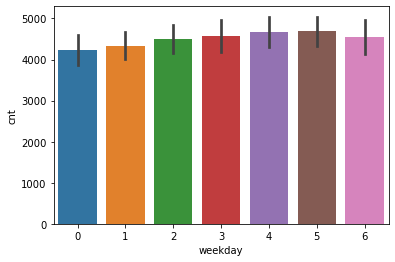

In [4]:
sns.barplot(x = bike['weekday'] , y = bike['cnt'])
plt.show()

<AxesSubplot:xlabel='mnth', ylabel='cnt'>

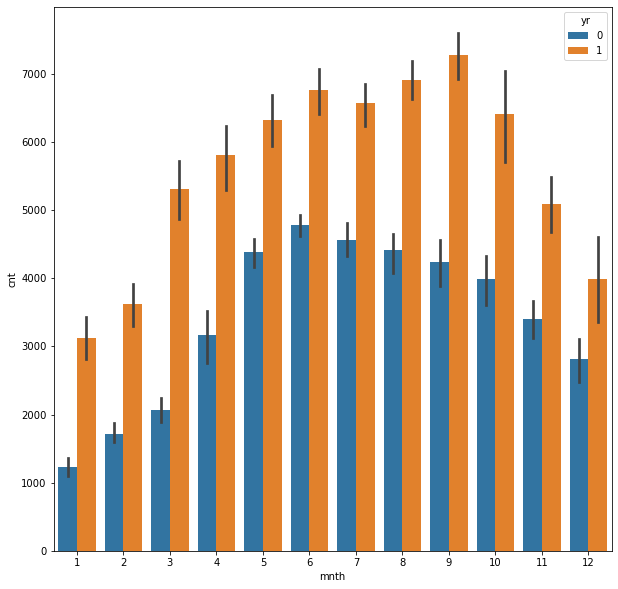

In [5]:
plt.figure(figsize=(10,10))
sns.barplot(x = bike['mnth'] , y = bike['cnt'],hue=bike['yr'])

Lets analyse the heamaps with and without the dependent variable

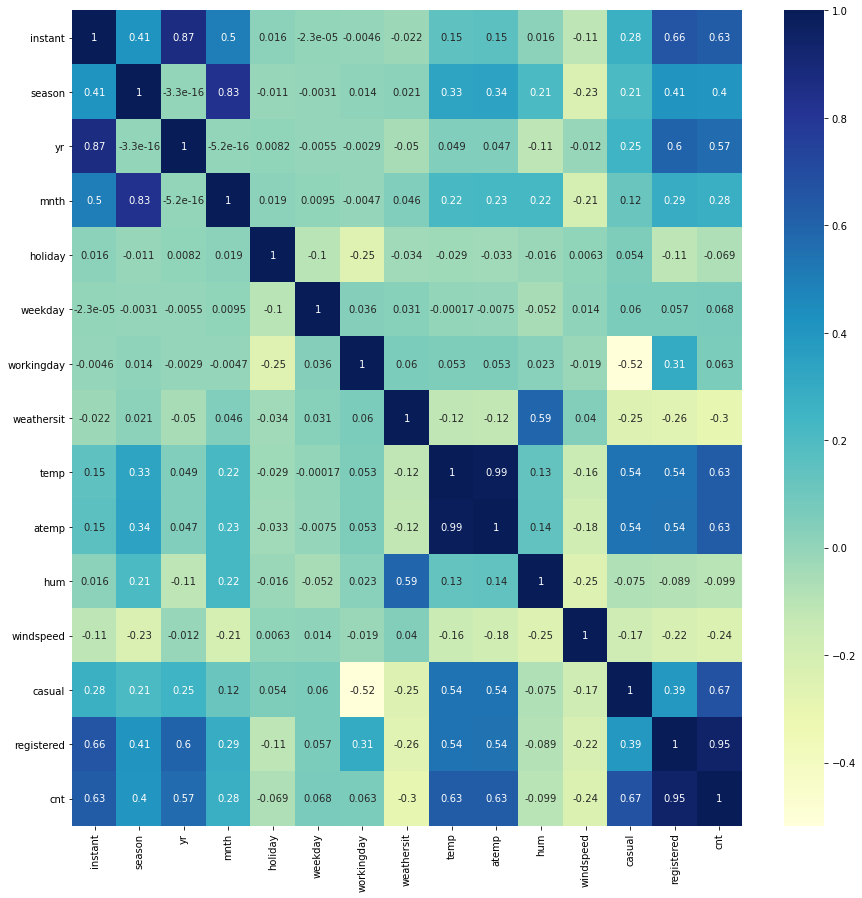

In [6]:
plt.figure(figsize=(15,15))
sns.heatmap(bike.corr(), cmap="YlGnBu", annot = True)
plt.show()

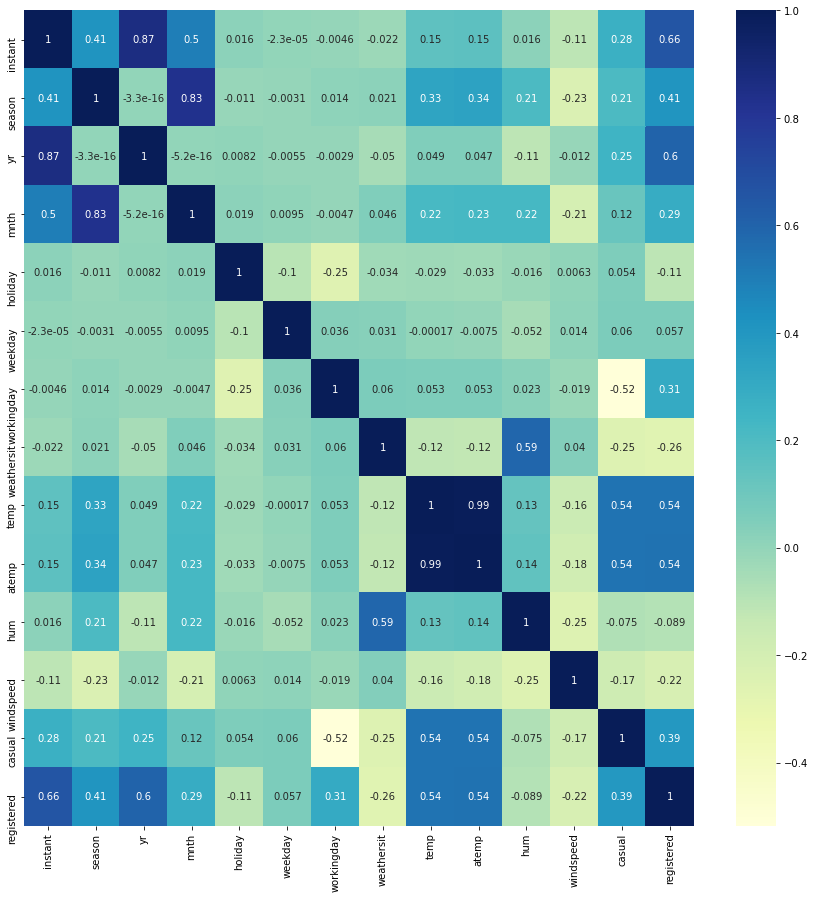

In [7]:
plt.figure(figsize=(15,15))
sns.heatmap(bike.drop(['cnt'],axis=1).corr(), cmap="YlGnBu", annot = True)
plt.show()

dropping instant since it is just an index 

In [8]:
bike=bike.drop(['instant'],axis=1)

Lets convet the weathersit , weekday ,month and season into dummy variables since 1,2,3,4 will be ambiguous for training

In [9]:
bike=pd.get_dummies(bike,prefix='wsit',columns=['weathersit'],drop_first=True,dtype=int)
bike=pd.get_dummies(bike,prefix='day',columns=['weekday'],drop_first=True,dtype=int)
bike=pd.get_dummies(bike,prefix='month',columns=['mnth'],drop_first=True,dtype=int)
bike=pd.get_dummies(bike,prefix='season',columns=['season'],drop_first=True,dtype=int)

In [10]:
print(bike.columns)

Index(['dteday', 'yr', 'holiday', 'workingday', 'temp', 'atemp', 'hum',
       'windspeed', 'casual', 'registered', 'cnt', 'wsit_2', 'wsit_3', 'day_1',
       'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12', 'season_2', 'season_3', 'season_4'],
      dtype='object')


Lets drop these since they will not contribute towards the analysis

In [11]:
bike=bike.drop(['dteday','casual','registered'],axis=1)

In [12]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [13]:
X=bike.drop(['cnt'],axis=1)
y=bike['cnt']

In [14]:
from sklearn.model_selection import train_test_split
np.random.seed(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, test_size = 0.3, random_state = 100)

Before training the model , lets check for multicollinearity using vif

In [15]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

c:\users\anu25\anaconda3\envs\nse\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,Features,VIF
12,day_4,inf
13,day_5,inf
2,workingday,inf
1,holiday,inf
9,day_1,inf
10,day_2,inf
11,day_3,inf
3,temp,552.16
4,atemp,512.07
5,hum,24.46


Woah infinite value

This could be possible because day 1 to day 5 (Monday to Friday) are actually working days so they are perfectly related to the workingday feature

lets drop workingday and build the model 

In [16]:
X = X_train.drop('workingday', 1)

In [17]:
X_train_lm = sm.add_constant(X)

lr_2 = sm.OLS(y_train, X_train_lm).fit()

In [18]:
print(lr_2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     99.96
Date:                Tue, 09 Mar 2021   Prob (F-statistic):          8.42e-181
Time:                        23:07:08   Log-Likelihood:                -4097.8
No. Observations:                 510   AIC:                             8254.
Df Residuals:                     481   BIC:                             8376.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1391.5393    283.083      4.916      0.0

Multicollinearity still exists
Lets check vif again

In [19]:
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,temp,552.16
3,atemp,512.07
4,hum,24.46
26,season_3,15.42
20,month_8,11.03
27,season_4,10.93
19,month_7,9.66
25,season_2,8.88
18,month_6,7.41
21,month_9,7.35


Temp has an absurdly high vif

In [20]:
X = X.drop('temp', 1)

In [21]:
X_train_lm = sm.add_constant(X)

lr_3 = sm.OLS(y_train, X_train_lm).fit()

In [22]:
print(lr_3.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     101.9
Date:                Tue, 09 Mar 2021   Prob (F-statistic):          4.12e-180
Time:                        23:07:08   Log-Likelihood:                -4101.9
No. Observations:                 510   AIC:                             8260.
Df Residuals:                     482   BIC:                             8378.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1301.6754    283.308      4.595      0.0

In [23]:
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,atemp,52.95
3,hum,24.45
25,season_3,15.33
26,season_4,10.92
19,month_8,10.23
18,month_7,9.09
24,season_2,8.88
20,month_9,7.07
17,month_6,6.86
16,month_5,6.85


Removing atemp too

In [24]:
X = X.drop('atemp', 1)

In [25]:
X_train_lm = sm.add_constant(X)

lr_4 = sm.OLS(y_train, X_train_lm).fit()

In [26]:
print(lr_4.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     87.25
Date:                Tue, 09 Mar 2021   Prob (F-statistic):          3.67e-164
Time:                        23:07:09   Log-Likelihood:                -4143.6
No. Observations:                 510   AIC:                             8341.
Df Residuals:                     483   BIC:                             8456.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1933.4303    298.036      6.487      0.0

In [27]:
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,hum,16.16
24,season_3,15.16
25,season_4,10.90
23,season_2,8.88
18,month_8,7.57
3,windspeed,6.20
17,month_7,6.19
20,month_10,5.76
21,month_11,5.74
19,month_9,5.59


hum still has a high vif . lets remove that as well

In [28]:
X = X.drop('hum', 1)

In [29]:
X_train_lm = sm.add_constant(X)

lr_6 = sm.OLS(y_train, X_train_lm).fit()

In [30]:
print(lr_6.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     90.59
Date:                Tue, 09 Mar 2021   Prob (F-statistic):          7.93e-165
Time:                        23:07:09   Log-Likelihood:                -4144.4
No. Observations:                 510   AIC:                             8341.
Df Residuals:                     484   BIC:                             8451.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1654.1078    190.184      8.697      0.0

In [31]:
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
23,season_3,15.15
24,season_4,10.87
22,season_2,8.87
17,month_8,7.17
16,month_7,5.87
2,windspeed,5.84
20,month_11,5.48
19,month_10,5.38
18,month_9,5.19
14,month_5,4.58


Season 3 does have the highest vif but that is to be expected in dummy variables

This is because if season 3 has value 1 then obviously season 4 and season 2 will have values 0 . Thus the high vif value.

Windspeed has the highest vif disregarding dummy variables , lets remove that too.

In [32]:
X=X.drop('windspeed',1)

In [33]:
X_train_lm = sm.add_constant(X)

lr_7 = sm.OLS(y_train, X_train_lm).fit()

In [34]:
print(lr_7.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.810
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     85.97
Date:                Tue, 09 Mar 2021   Prob (F-statistic):          1.06e-157
Time:                        23:07:09   Log-Likelihood:                -4164.2
No. Observations:                 510   AIC:                             8378.
Df Residuals:                     485   BIC:                             8484.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1044.8419    169.708      6.157      0.0

The Durbin watson value is less than 2 as well

In [35]:
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
22,season_3,15.07
23,season_4,10.72
21,season_2,8.84
16,month_8,6.95
15,month_7,5.66
19,month_11,5.08
18,month_10,5.01
17,month_9,5.01
13,month_5,4.37
12,month_4,4.14


All good !!

Lets proceed to residual analysis

In [36]:
y_train_pred = lr_7.predict(X_train_lm)
res = (y_train - y_train_pred)

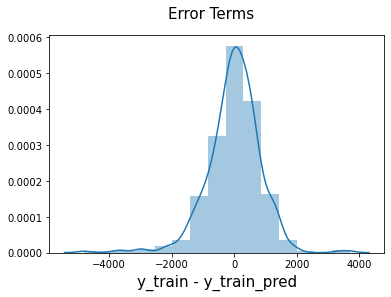

In [37]:
fig = plt.figure()
sns.distplot(res, bins = 15)
fig.suptitle('Error Terms', fontsize = 15)                  # Plot heading 
plt.xlabel('y_train - y_train_pred', fontsize = 15)         # X-label
plt.show()

The residuals are centred around the mean which is good

Now lets make predictions using this model

In [38]:
X_test=X_test.drop(['temp','hum','workingday','windspeed','atemp'],axis=1)

X_test_sm = sm.add_constant(X_test)
y_pred = lr_7.predict(X_test_sm)

In [39]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

0.8128739004678658

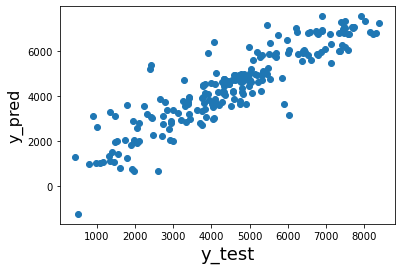

In [40]:
plt.scatter(y_test, y_pred)
fig.suptitle('y_test vs y_pred', fontsize = 20)              
plt.xlabel('y_test', fontsize = 18)                          
plt.ylabel('y_pred', fontsize = 16) 
plt.show()

The model has achieved a decent r2 score